In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings('ignore')

In [166]:
df= pd.read_csv("cumulative_daily_cases.csv")

In [167]:
df.cases_dates = pd.to_datetime(df.cases_dates)
df = df.set_index('cases_dates')
df = df[['Confirmed']].diff().fillna(0)
df = df.iloc[1:]


In [168]:
df.head()

,Confirmed
cases_dates,
2020-01-23,99.0
2020-01-24,287.0
2020-01-25,493.0
2020-01-26,684.0
2020-01-27,809.0


In [169]:
train, test = train_test_split(df, test_size=0.5, shuffle=False)

In [170]:
scaler =  MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [171]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, test, length=n_input, batch_size=6)
model = Sequential()
model.add(LSTM(200, activation="relu", input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.fit_generator(generator, epochs=200)

Epoch 1/200
5/5 [==============================] - 0s 91ms/step - loss: 15.2501
Epoch 2/200
5/5 [==============================] - 0s 20ms/step - loss: 14.5663
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 13.4715
Epoch 4/200
5/5 [==============================] - 0s 20ms/step - loss: 9.0546
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 7.2777
Epoch 6/200
5/5 [==============================] - 0s 30ms/step - loss: 3.5826
Epoch 7/200
5/5 [==============================] - 0s 29ms/step - loss: 6.2669
Epoch 8/200
5/5 [==============================] - 0s 28ms/step - loss: 6.5793
Epoch 9/200
5/5 [==============================] - 0s 28ms/step - loss: 5.1967
Epoch 10/200
5/5 [==============================] - 0s 29ms/step - loss: 2.9394
Epoch 11/200
5/5 [==============================] - 0s 26ms/step - loss: 3.3288
Epoch 12/200
5/5 [==============================] - 0s 25ms/step - loss: 3.4814
Epoch 13/200
5/5 [============================

5/5 [==============================] - 0s 8ms/step - loss: 2.1972
Epoch 104/200
5/5 [==============================] - 0s 10ms/step - loss: 2.1829
Epoch 105/200
5/5 [==============================] - 0s 10ms/step - loss: 2.3857
Epoch 106/200
5/5 [==============================] - 0s 23ms/step - loss: 2.2077
Epoch 107/200
5/5 [==============================] - 0s 9ms/step - loss: 2.1022
Epoch 108/200
5/5 [==============================] - 0s 22ms/step - loss: 2.0314
Epoch 109/200
5/5 [==============================] - 0s 12ms/step - loss: 2.2250
Epoch 110/200
5/5 [==============================] - 0s 24ms/step - loss: 2.1362
Epoch 111/200
5/5 [==============================] - 0s 25ms/step - loss: 2.2248
Epoch 112/200
5/5 [==============================] - 0s 31ms/step - loss: 2.3051
Epoch 113/200
5/5 [==============================] - 0s 31ms/step - loss: 2.1733
Epoch 114/200
5/5 [==============================] - 0s 30ms/step - loss: 2.1112
Epoch 115/200
5/5 [=========================

In [172]:
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)
    

In [173]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df[-n_input:].index, columns=['Predictions'])
df_test = pd.concat([df, df_predict], axis=1)
print(tabulate(df_test))

-------------------  ------  ---------
2020-01-23 00:00:00      99    nan
2020-01-24 00:00:00     287    nan
2020-01-25 00:00:00     493    nan
2020-01-26 00:00:00     684    nan
2020-01-27 00:00:00     809    nan
2020-01-28 00:00:00    2651    nan
2020-01-29 00:00:00     588    nan
2020-01-30 00:00:00    2068    nan
2020-01-31 00:00:00    1693    nan
2020-02-01 00:00:00    2111    nan
2020-02-02 00:00:00    4749    nan
2020-02-03 00:00:00    3094    nan
2020-02-04 00:00:00    4011    nan
2020-02-05 00:00:00    3743    nan
2020-02-06 00:00:00    3159    nan
2020-02-07 00:00:00    3597    nan
2020-02-08 00:00:00    2729    nan
2020-02-09 00:00:00    3030    nan
2020-02-10 00:00:00    2612    nan
2020-02-11 00:00:00    2040    nan
2020-02-12 00:00:00     419    nan
2020-02-13 00:00:00   15147    nan
2020-02-14 00:00:00    6517    nan
2020-02-15 00:00:00    2145    nan
2020-02-16 00:00:00    2194    nan
2020-02-17 00:00:00    2034    nan
2020-02-18 00:00:00    1878    nan
2020-02-19 00:00

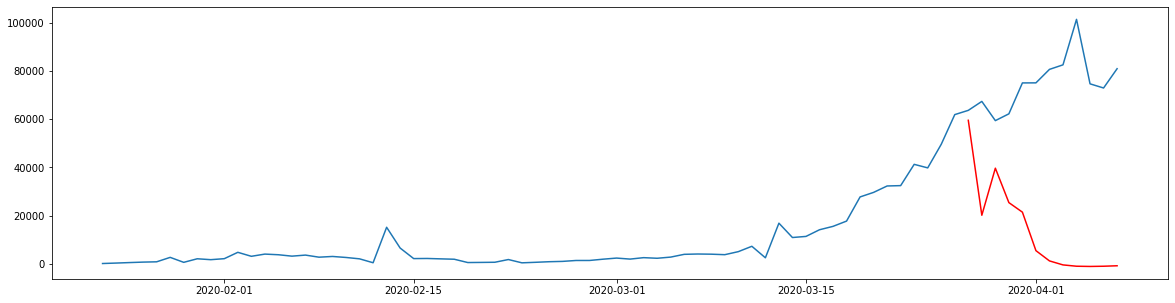

In [174]:
plt.figure(figsize=(20,5))
plt.plot(df_test.index, df_test['Confirmed'])
plt.plot(df_test.index, df_test['Predictions'], color='r')
plt.show()


In [175]:
train = df
scaler.fit(train)
train = scaler.transform(train)
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator, epochs=200)
pred_list = []
batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis=1)

Epoch 1/200
11/11 [==============================] - 0s 9ms/step - loss: 3.2186
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.1564
Epoch 3/200
11/11 [==============================] - 0s 10ms/step - loss: 0.1398
Epoch 4/200
11/11 [==============================] - 0s 9ms/step - loss: 0.1261
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 0.1141
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0891
Epoch 7/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0710
Epoch 8/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 9/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0279
Epoch 10/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0302
Epoch 11/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0377
Epoch 12/200
11/11 [==============================] - 0s 10ms/step - loss: 0.0313
Epoch 13/200
11/11 [===============

11/11 [==============================] - 0s 8ms/step - loss: 0.0039
Epoch 102/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0046
Epoch 103/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 104/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0017
Epoch 105/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0030
Epoch 106/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0025
Epoch 107/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 108/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0022
Epoch 109/200
11/11 [==============================] - 0s 8ms/step - loss: 0.0031
Epoch 110/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 111/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 112/200
11/11 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 113/200
11/11 [=========

In [176]:
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0,13)] #just 30for convinience
future_dates = pd.DataFrame(index=add_dates[1:], columns=df.columns)
print(future_dates)

           Confirmed
2020-04-08       NaN
2020-04-09       NaN
2020-04-10       NaN
2020-04-11       NaN
2020-04-12       NaN
2020-04-13       NaN
2020-04-14       NaN
2020-04-15       NaN
2020-04-16       NaN
2020-04-17       NaN
2020-04-18       NaN
2020-04-19       NaN


In [177]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=future_dates.index, columns=['Predictions'])

df_proj = pd.concat([df,df_predict], axis=1)

In [178]:
print(tabulate(df_proj))

-------------------  ------  -------
2020-01-23 00:00:00      99    nan
2020-01-24 00:00:00     287    nan
2020-01-25 00:00:00     493    nan
2020-01-26 00:00:00     684    nan
2020-01-27 00:00:00     809    nan
2020-01-28 00:00:00    2651    nan
2020-01-29 00:00:00     588    nan
2020-01-30 00:00:00    2068    nan
2020-01-31 00:00:00    1693    nan
2020-02-01 00:00:00    2111    nan
2020-02-02 00:00:00    4749    nan
2020-02-03 00:00:00    3094    nan
2020-02-04 00:00:00    4011    nan
2020-02-05 00:00:00    3743    nan
2020-02-06 00:00:00    3159    nan
2020-02-07 00:00:00    3597    nan
2020-02-08 00:00:00    2729    nan
2020-02-09 00:00:00    3030    nan
2020-02-10 00:00:00    2612    nan
2020-02-11 00:00:00    2040    nan
2020-02-12 00:00:00     419    nan
2020-02-13 00:00:00   15147    nan
2020-02-14 00:00:00    6517    nan
2020-02-15 00:00:00    2145    nan
2020-02-16 00:00:00    2194    nan
2020-02-17 00:00:00    2034    nan
2020-02-18 00:00:00    1878    nan
2020-02-19 00:00:0

No handles with labels found to put in legend.


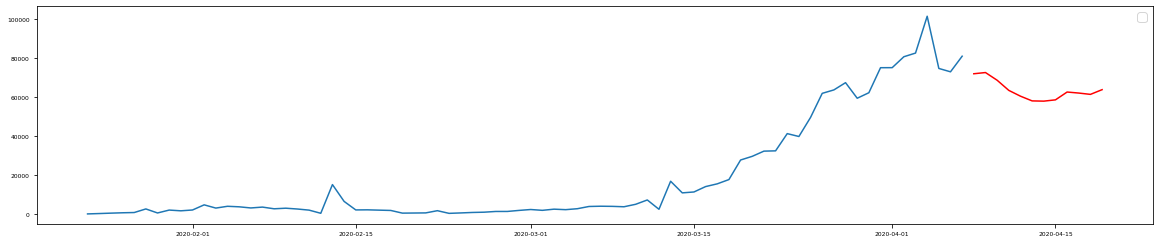

In [180]:
plt.figure(figsize=(20,4))
plt.plot(df_proj.index, df_proj['Confirmed'])
plt.plot(df_proj.index, df_proj['Predictions'], color="r")
plt.legend(loc="best", fontsize="large")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()